### Лабораторная работа №4: **Анализ тональности текста с использованием Word2Vec и логистической регрессии**

#### Теоретическая часть

**Анализ тональности (sentiment analysis)** – это процесс определения эмоциональной окраски текста (положительной, отрицательной или нейтральной). **Word2Vec** – это алгоритм для обучения векторных представлений слов, который позволяет эффективно представлять слова в виде векторов. Логистическая регрессия – это метод классификации, который хорошо подходит для бинарных задач, таких как классификация тональности.

#### Практическая задача

Выполните анализ тональности отзывов о фильмах, используя Word2Vec и логистическую регрессию:

1. Загрузите и предобработайте данные: удалите стоп-слова, проведите лемматизацию/стемминг, преобразуйте все буквы в нижний регистр.
2. Обучите модель Word2Vec на вашем наборе данных.
3. Преобразуйте каждый отзыв в векторное представление с использованием Word2Vec.
4. Постройте модель логистической регрессии для классификации тональности отзывов.
5. Проверьте точность модели на тестовом наборе.
6. Проанализируйте результаты и сделайте выводы о качестве классификации.

#### Указания по выполнению

1. Используйте библиотеку `gensim` для обучения модели Word2Vec.
2. Экспериментируйте с различными параметрами модели Word2Vec (размер вектора, окно контекста, метод обучения).
3. Используйте библиотеку `sklearn` для построения и оценки модели логистической регрессии.
4. Подготовьте отчет, включающий код, графики и таблицы с результатами экспериментов.

In [6]:
from nltk.corpus import movie_reviews, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import optuna

### 1. Загрузите и предобработайте данные: удалите стоп-слова, проведите лемматизацию/стемминг, преобразуйте все буквы в нижний регистр.


In [2]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

processed_reviews = {} 

for fileid in movie_reviews.fileids():
    text = movie_reviews.raw(fileid)
    tokens = word_tokenize(text)
    processed_tokens = [
        lemmatizer.lemmatize(token.lower()) 
        for token in tokens 
        if token.isalpha() and token.lower() not in stop_words
    ]
    processed_reviews[fileid] = processed_tokens

example_file = movie_reviews.fileids()[0]
print(processed_reviews[example_file][:20])

['plot', 'two', 'teen', 'couple', 'go', 'church', 'party', 'drink', 'drive', 'get', 'accident', 'one', 'guy', 'dy', 'girlfriend', 'continues', 'see', 'life', 'nightmare', 'deal']


### 2. Обучите модель Word2Vec на вашем наборе данных.


In [3]:
sentences = list(processed_reviews.values())

w2v_model = Word2Vec(sentences, vector_size=297, window=5, min_count=3, workers=4, epochs=18, sg=1)

print(w2v_model.wv['good'][:10])

[-0.02622952  0.2600906  -0.10941063 -0.01792035 -0.29135448 -0.21996164
 -0.15253153  0.03774976  0.27502638  0.14161105]


### 3. Преобразуйте каждый отзыв в векторное представление с использованием Word2Vec.


In [4]:
review_vectors = {} 

for fileid, tokens in processed_reviews.items():
    word_vectors = [w2v_model.wv[token] for token in tokens if token in w2v_model.wv]
    if word_vectors: 
        review_vector = np.mean(word_vectors, axis=0)
    else:
        review_vector = np.zeros(w2v_model.vector_size)
    review_vectors[fileid] = review_vector

len(review_vectors)

2000

### 4. Постройте модель логистической регрессии для классификации тональности отзывов.


In [5]:
X = []
y = []

for fileid, vector in review_vectors.items():
    X.append(vector)
    label = 1 if fileid.startswith('pos') else 0
    y.append(label)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

### 5. Проверьте точность модели на тестовом наборе.


In [26]:
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.775

In [ ]:
clf = RidgeClassifier(alpha=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8125

In [18]:
def objective(trial):
    vector_size = trial.suggest_int('vector_size', 50, 300)
    window = trial.suggest_int('window', 2, 10)
    min_count = trial.suggest_int('min_count', 1, 5)
    sg = trial.suggest_categorical('sg', [0, 1])  
    epochs = trial.suggest_int('epochs', 5, 20)
    
    model = Word2Vec(
        sentences,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=sg,
        workers=4,
        epochs=epochs
    )
    
    review_vectors = {}
    for fileid, tokens in processed_reviews.items():
        word_vectors = [model.wv[token] for token in tokens if token in model.wv]
        if word_vectors:  
            review_vector = np.mean(word_vectors, axis=0)
        else:
            review_vector = np.zeros(vector_size)
        review_vectors[fileid] = review_vector
    
    X, y = [], []
    for fileid, vector in review_vectors.items():
        X.append(vector)
        label = 1 if fileid.startswith('pos') else 0
        y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-04-03 17:51:49,599] A new study created in memory with name: no-name-6f00cda1-b1a5-4986-b767-6133c6d2257a
[I 2025-04-03 17:51:55,428] Trial 0 finished with value: 0.6375 and parameters: {'vector_size': 132, 'window': 7, 'min_count': 1, 'sg': 1, 'epochs': 6}. Best is trial 0 with value: 0.6375.
[I 2025-04-03 17:51:58,238] Trial 1 finished with value: 0.675 and parameters: {'vector_size': 121, 'window': 7, 'min_count': 2, 'sg': 0, 'epochs': 10}. Best is trial 1 with value: 0.675.
[I 2025-04-03 17:52:27,479] Trial 2 finished with value: 0.7425 and parameters: {'vector_size': 279, 'window': 8, 'min_count': 3, 'sg': 1, 'epochs': 13}. Best is trial 2 with value: 0.7425.
[I 2025-04-03 17:52:31,081] Trial 3 finished with value: 0.7325 and parameters: {'vector_size': 256, 'window': 5, 'min_count': 5, 'sg': 0, 'epochs': 16}. Best is trial 2 with value: 0.7425.
[I 2025-04-03 17:52:34,107] Trial 4 finished with value: 0.6275 and parameters: {'vector_size': 186, 'window': 2, 'min_count': 4,

KeyboardInterrupt: 

In [22]:
trial = study.best_trial
print(trial.value)
trial.params.items()

0.7825


dict_items([('vector_size', 297), ('window', 5), ('min_count', 3), ('sg', 1), ('epochs', 18)])

### 6. Проанализируйте результаты и сделайте выводы о качестве классификации.


In [27]:
report = classification_report(y_test, y_pred, target_names=['neg', 'pos'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         neg       0.76      0.81      0.78       199
         pos       0.80      0.74      0.77       201

    accuracy                           0.78       400
   macro avg       0.78      0.78      0.77       400
weighted avg       0.78      0.78      0.77       400



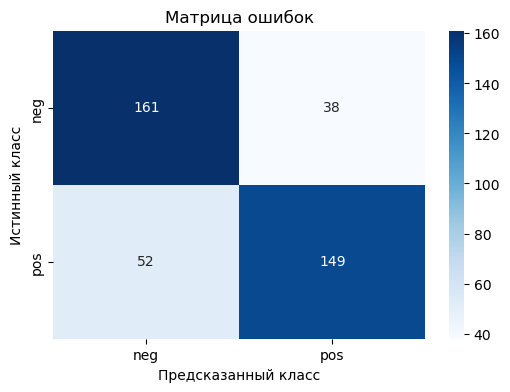

In [28]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Матрица ошибок")
plt.show()